# ★初期設定

### Instructions for setting up `DemandSupplySimulation` environment.

<p>Click to copy each command:</p>

1. **Open Terminal**  
   - Click on `Terminal` -> `New Terminal`

2. **Run Environment Creation Command**
   - Command: `conda env create -f pypsa_tepsco_env.yml`  
     <button onclick="navigator.clipboard.writeText('conda env create -f pypsa_tepsco_env.yml')">Copy Command</button>

3. **Update Existing Environment**  
   - Command: `conda env update -f pypsa_tepsco_env.yml --prune`  
     <button onclick="navigator.clipboard.writeText('conda env update -f pypsa_tepsco_env.yml --prune')">Copy Command</button>

4. **If `conda` is Not Available**  
   - Follow the additional instructions below.

# ★まとめて実行

In [ ]:
%reset -f
import pypsa, os, sys, importlib, shutil, warnings, pandas as pd, numpy as np, matplotlib.pyplot as plt
sys.path.append(os.getcwd())

# モジュールを強制的にリロード（pypsa_tepsco.pyの変更内容を反映。これをしないと、キャッシュに残っている古いコードが実行される）
import pypsa_tepsco
importlib.reload(pypsa_tepsco)

#warnings.filterwarnings("ignore", category=UserWarning, module='openpyxl')
# Set pandas options
pd.set_option('display.max_columns', None)
#pd.options.plotting.backend = 'plotly'
os.makedirs('complete_network', exist_ok=True)
os.makedirs('combined_plots', exist_ok=True)

Year_of_analysis = 2024 # 年度の設定
demand_change_compared_to_2024 = 10 # %
file_name = "pypsa-japan-tx-network-10BusModel-v0.xlsx" # ネットワークファイルの設定
demand_file_name = "demand_data/japan-demand(10Bus).csv" # デマンドファイルの設定

############################################################################################
# 1. Create a dataframe with hourly date-time stamps for the entire year (full year)
snapshots = pd.date_range(f"{Year_of_analysis}-01-01 00:00",
                          f"{Year_of_analysis}-01-31 23:00",
                          freq="h")
# 2. Remove February 29 to handle leap years
snapshots = snapshots[~((snapshots.month == 2) & (snapshots.day == 29))]

# 3. 静的データ（ネットワークデータ）をインポートしてnetworkに格納
network = pypsa.Network(file_name)

# 需要データのインポート
network.set_snapshots(snapshots)
pypsa_tepsco.import_demand_data(network, demand_file_name, demand_change_compared_to_2024)

# 最適化実行 solver=highsに指定 gurobi
network.optimize(solver_name='highs')


INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores


                    Day of week  Week of year  北海道D   東北D    東京D    中部D  \
Date                                                                      
2024-01-01 00:00:00    Saturday             1  3811  7471  24024   9991   
2024-01-01 01:00:00    Saturday             1  3917  7515  22864   9710   
2024-01-01 02:00:00    Saturday             1  4019  7659  22433   9807   
2024-01-01 03:00:00    Saturday             1  4102  7857  22292   9948   
2024-01-01 04:00:00    Saturday             1  4118  7991  22294   9937   
...                         ...           ...   ...   ...    ...    ...   
2024-12-31 19:00:00      Sunday            53  3777  9456  31283  12998   
2024-12-31 20:00:00      Sunday            53  3818  9220  30893  12820   
2024-12-31 21:00:00      Sunday            53  3879  9113  30110  12543   
2024-12-31 22:00:00      Sunday            53  3831  8918  29057  12114   
2024-12-31 23:00:00      Sunday            53  4057  9089  28359  12085   

                        

INFO:linopy.model: Solve problem using Cplex solver


AssertionError: Solver cplex not installed

# 送電線の潮流を表示

In [90]:
network.links_t.p0.plot(title="Power Flow in Transmission Lines")

# 発電出力を表示

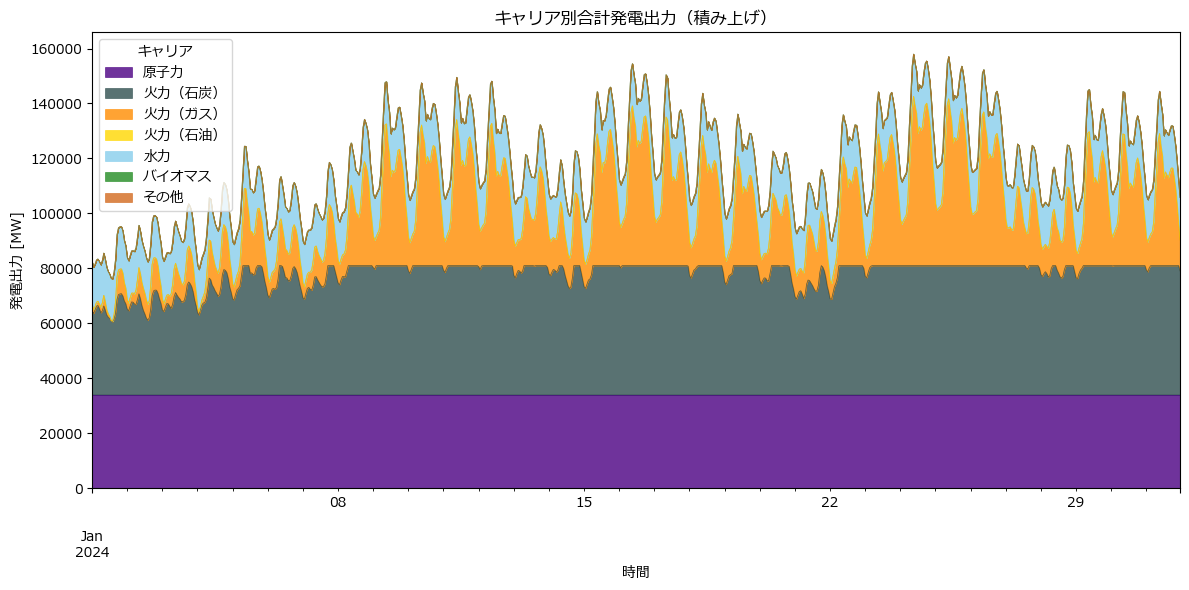

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
pd.options.plotting.backend = "matplotlib"  # プロットバックエンドをmatplotlibに
plt.rcParams['font.family'] = 'Meiryo'  # または 'Meiryo', 'Yu Gothic' MS Gothic
plt.rcParams['axes.unicode_minus'] = False  # マイナス符号も文字化け防止
# 各generatorがどのcarrierかを取得
carrier_map = network.generators['carrier']

# generator名→carrier名の辞書
gen_to_carrier = carrier_map.to_dict()

# generators_t.pの列（generator名）ごとにcarrierでgroupbyして合計
carrier_output = {}
for gen, carrier in gen_to_carrier.items():
    if carrier not in carrier_output:
        carrier_output[carrier] = network.generators_t.p[gen]
    else:
        carrier_output[carrier] += network.generators_t.p[gen]

# DataFrame化（index=時系列、columns=carrier）
import pandas as pd
carrier_output_df = pd.DataFrame(carrier_output)



# グラフ描画
# キャリアの順序および色を指定（下から上に積み上がる順）
desired_order = ["原子力", "火力（石炭）", "火力（ガス）", "火力（石油）","水力", "バイオマス", "その他"]
color_list = ["#4B0082", "#2F4F4F", "#FF8C00", "#FFD700", "#87CEEB", "#228B22", "#D2691E"]
# 指定順で列を並び替える（存在する列だけ抽出）
ordered_columns = [col for col in desired_order if col in carrier_output_df.columns]
carrier_output_df = carrier_output_df[ordered_columns]

# グラフ描画
carrier_output_df.plot(
    kind="area", 
    stacked=True, 
    figsize=(12,6),
    alpha=0.8,
    color=color_list,
    linewidth=0.5
)
plt.title("キャリア別合計発電出力（積み上げ）")
plt.xlabel("時間")
plt.ylabel("発電出力 [MW]")
plt.legend(title="キャリア")
plt.tight_layout()
plt.show()


In [5]:
network.export_to_hdf5('complete_network/unsolved_model.h5')

INFO:pypsa.io:Exported network unsolved_model.h5 has generators, carriers, stores, links, loads, buses


# 地図上にプロットする。

In [71]:
import folium
import pandas as pd

# Helper: try various column names and return DataFrame with lat/lon
def _get_bus_locations_df(network):
    df = network.buses.copy()
    # common PyPSA default: x (lon), y (lat)
    if {'y','x'}.issubset(df.columns):
        df = df.rename(columns={'y':'lat','x':'lon'})
    # already lat/lon
    elif {'lat','lon'}.issubset(df.columns):
        pass
    # alternative naming
    elif {'latitude','longitude'}.issubset(df.columns):
        df = df.rename(columns={'latitude':'lat','longitude':'lon'})
    # some workflows store coords in a list/tuple column called 'coords'
    elif 'coords' in df.columns:
        coords = df['coords'].apply(lambda v: (v[0], v[1]) if isinstance(v, (list,tuple)) and len(v)>=2 else (None,None))
        df[['lat','lon']] = pd.DataFrame(coords.tolist(), index=df.index)
    else:
        raise ValueError("network.busesに位置情報のカラムが見つかりません。期待される: x/y, lon/lat, latitude/longitude, or coords")

    # ensure numeric and drop invalid rows
    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df = df.dropna(subset=['lat','lon'])
    if df.empty:
        raise ValueError("有効なバス座標が見つかりません。")
    return df[['lat','lon']]

# get bus locations (raises helpful error if not found)
bus_locations = _get_bus_locations_df(network)

# 地図の中心をバスの平均位置に設定
center_lat = bus_locations['lat'].mean()
center_lon = bus_locations['lon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=5)

# バスごとにマーカーを追加
for bus_name, row in bus_locations.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=str(bus_name),
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

# 保存と表示
m.save('bus_locations_map.html')

m

In [ ]:
# プロット: バスとリンク（network.links / network.lines）を地図上に描画して保存
# 既に folium, network, Year_of_analysis が定義されている前提
import folium

# 再利用可能なバス位置取得関数 (cell '#VSC-50c70af2' と同じロジック)
def _get_bus_locations_df(network):
    df = network.buses.copy()
    if {'y','x'}.issubset(df.columns):
        df = df.rename(columns={'y':'lat','x':'lon'})
    elif {'lat','lon'}.issubset(df.columns):
        pass
    elif {'latitude','longitude'}.issubset(df.columns):
        df = df.rename(columns={'latitude':'lat','longitude':'lon'})
    elif 'coords' in df.columns:
        coords = df['coords'].apply(lambda v: (v[0], v[1]) if isinstance(v, (list,tuple)) and len(v)>=2 else (None,None))
        df[['lat','lon']] = pd.DataFrame(coords.tolist(), index=df.index)
    else:
        raise ValueError("network.busesに位置情報のカラムが見つかりません。期待される: x/y, lon/lat, latitude/longitude, or coords")

    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df = df.dropna(subset=['lat','lon'])
    if df.empty:
        raise ValueError("有効なバス座標が見つかりません。")
    return df[['lat','lon']]

# バス位置取得
bus_locations = _get_bus_locations_df(network)

m_links = folium.Map(location=[bus_locations['lat'].mean(), bus_locations['lon'].mean()], zoom_start=5)

# バスをマーカーで追加
for bus_name, r in bus_locations.iterrows():
    folium.CircleMarker(
        location=[r['lat'], r['lon']],
        radius=6,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.8,
        popup=str(bus_name)
    ).add_to(m_links)

# 汎用的にリンクのバス列を検出して描画する関数
def _plot_links_from_df(df, color='#d63333', weight=3, prefix=''):
    bus_cols = [c for c in df.columns if c.startswith('bus')]
    if len(bus_cols) < 2:
        return 0
    count = 0
    for name, row in df.iterrows():
        b0 = row[bus_cols[0]]
        b1 = row[bus_cols[1]]
        # bus 名が bus_locations にあるか確認
        if (b0 in bus_locations.index) and (b1 in bus_locations.index):
            coords = [
                [bus_locations.loc[b0, 'lat'], bus_locations.loc[b0, 'lon']],
                [bus_locations.loc[b1, 'lat'], bus_locations.loc[b1, 'lon']]
            ]
            popup = f"{prefix}{name}: {b0} ↔ {b1}"
            folium.PolyLine(coords, color=color, weight=weight, opacity=0.7, popup=popup).add_to(m_links)
            count += 1
    return count

# network.links があれば描画
links_plotted = 0
if hasattr(network, "links") and len(network.links) > 0:
    links_plotted += _plot_links_from_df(network.links, color='#ff4500', weight=3, prefix='link ')

# network.lines があれば描画（存在するネットワークでは lines が無い場合もある）
if hasattr(network, "lines") and len(network.lines) > 0:
    links_plotted += _plot_links_from_df(network.lines, color='#0066cc', weight=2, prefix='line ')

# 出力・保存
out_file = f'bus_links_map_{Year_of_analysis}.html'
m_links.save(out_file)
print(f"バス: {len(bus_locations)} 個、リンク描画: {links_plotted} 本。地図を保存しました -> {out_file}")

# Jupyter で表示するためにマップオブジェクトを返す
m_links


バス: 9 個、リンク描画: 16 本。地図を保存しました -> bus_links_map_2024.html


In [ ]:
# Duplicate plotting cell made robust as well
import folium

# re-use the helper from earlier; define again to be safe in isolation
def _get_bus_locations_df(network):
    df = network.buses.copy()
    if {'y','x'}.issubset(df.columns):
        df = df.rename(columns={'y':'lat','x':'lon'})
    elif {'lat','lon'}.issubset(df.columns):
        pass
    elif {'latitude','longitude'}.issubset(df.columns):
        df = df.rename(columns={'latitude':'lat','longitude':'lon'})
    elif 'coords' in df.columns:
        coords = df['coords'].apply(lambda v: (v[0], v[1]) if isinstance(v, (list,tuple)) and len(v)>=2 else (None,None))
        df[['lat','lon']] = pd.DataFrame(coords.tolist(), index=df.index)
    else:
        raise ValueError("network.busesに位置情報のカラムが見つかりません。期待される: x/y, lon/lat, latitude/longitude, or coords")

    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df = df.dropna(subset=['lat','lon'])
    if df.empty:
        raise ValueError("有効なバス座標が見つかりません。")
    return df[['lat','lon']]

bus_locations = _get_bus_locations_df(network)

m_links = folium.Map(location=[bus_locations['lat'].mean(), bus_locations['lon'].mean()], zoom_start=5)

# バスをマーカーで追加
for bus_name, r in bus_locations.iterrows():
    folium.CircleMarker(
        location=[r['lat'], r['lon']],
        radius=6,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.8,
        popup=str(bus_name)
    ).add_to(m_links)

# 汎用的にリンクのバス列を検出して描画する関数
def _plot_links_from_df(df, color='#d63333', weight=3, prefix=''):
    bus_cols = [c for c in df.columns if c.startswith('bus')]
    if len(bus_cols) < 2:
        return 0
    count = 0
    for name, row in df.iterrows():
        b0 = row[bus_cols[0]]
        b1 = row[bus_cols[1]]
        if (b0 in bus_locations.index) and (b1 in bus_locations.index):
            coords = [
                [bus_locations.loc[b0, 'lat'], bus_locations.loc[b0, 'lon']],
                [bus_locations.loc[b1, 'lat'], bus_locations.loc[b1, 'lon']]
            ]
            popup = f"{prefix}{name}: {b0} ↔ {b1}"
            folium.PolyLine(coords, color=color, weight=weight, opacity=0.7, popup=popup).add_to(m_links)
            count += 1
    return count

links_plotted = 0
if hasattr(network, "links") and len(network.links) > 0:
    links_plotted += _plot_links_from_df(network.links, color='#ff4500', weight=3, prefix='link ')

if hasattr(network, "lines") and len(network.lines) > 0:
    links_plotted += _plot_links_from_df(network.lines, color='#0066cc', weight=2, prefix='line ')

out_file = f'bus_links_map_{Year_of_analysis}.html'
m_links.save(out_file)
print(f"バス: {len(bus_locations)} 個、リンク描画: {links_plotted} 本。地図を保存しました -> {out_file}")

m_links


バス: 9 個、リンク描画: 16 本。地図を保存しました -> bus_links_map_2024.html
